<a href="https://colab.research.google.com/github/MRathmair/facial-expression-recognition/blob/main/facial_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import SGD

# Load and prepare data

In [20]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv("/content/drive/My Drive/fer2013.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:

print(df["Usage"].unique())

df["image"] = df["pixels"].apply(lambda x: np.array([int(xi) for xi in x.split()]).reshape(48,48))

df.head()

['Training' 'PublicTest' 'PrivateTest']


,emotion,pixels,Usage,image
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,"[[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, ..."
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,"[[151, 150, 147, 155, 148, 133, 111, 140, 170,..."
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,"[[231, 212, 156, 164, 174, 138, 161, 173, 182,..."
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,"[[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, ..."
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,"[[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 2..."


In [22]:
# split data into train and test sets
df_train = df[df["Usage"] == "Training"].drop("Usage", axis=1)
df_test = df[df["Usage"] != "Training"].drop("Usage", axis=1)

print("# of training and test examples:", df_train.shape[0], " and ", df_test.shape[0])

# of training and test examples: 28709  and  7178


In [23]:
# create dictionary translating integers to emotions
int_to_em = {0 : 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

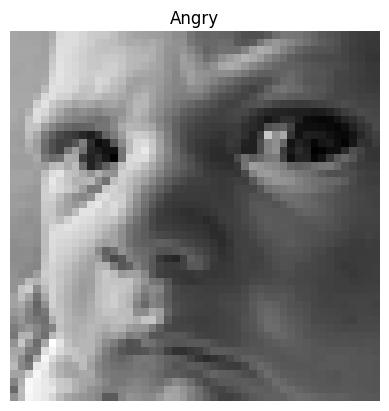

In [24]:
# look at a random training example
rnd_idx = np.random.randint(0,df_train.shape[0])

img = df_train["image"][rnd_idx]
plt.imshow(img, cmap="gray")
plt.title(int_to_em[df_train["emotion"][rnd_idx]])
plt.axis("off")
plt.show()

# Set up model classes

## Simple CNN

In [25]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size=3, padding='same'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2))
    self.block2 = nn.Sequential(nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=3, padding= 'same'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2))
    self.block3 = nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=3, padding = 'same'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2))
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=7)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = x.flatten(start_dim=1)
    return self.fc3(self.dropout(F.relu(self.fc2(self.dropout(F.relu(self.fc1(x)))))))

## VGG

In [26]:
class VGGModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding ='same'),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2))
    self.block2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding = 'same'),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding = 'same'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2))
    self.block3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding ='same'),
                                nn.ReLU(),
                                nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding = 'same'),
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2))
    self.fc1 = nn.Linear(in_features=6*6*256, out_features=512)
    self.fc2 = nn.Linear(in_features=512, out_features=256)
    self.fc3 = nn.Linear(in_features=256, out_features=7)
    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = x.flatten(start_dim=1)
    return self.fc3(self.dropout(F.relu(self.fc2(self.dropout(F.relu(self.fc1(x)))))))

# Auxiliary functions

In [27]:
def number_of_correct_predictions(logits, y_true):
  y_pred = logits.argmax(dim=-1)
  return (y_pred == y_true).sum().item()

In [28]:
def test_model(model, dataloader, loss_fn):
  loss = 0
  acc = 0

  model.eval()
  with torch.inference_mode():
    for X, y in dataloader:
      X = X.unsqueeze(1).to(device)
      y = y.to(device)
      logits = model(X)
      loss += loss_fn(logits, y).item()
      acc += number_of_correct_predictions(logits, y)

  loss /= len(dataloader.dataset)
  acc /= len(dataloader.dataset)

  return loss, acc

In [29]:
def make_prediction(model, image):
  model.eval()
  with torch.inference_mode():
    logits = model(image.unsqueeze(0).unsqueeze(0).to(device))
    return int_to_em[logits.argmax(dim=-1).item()]

# Training

In [30]:
#device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


## Loss function

<Axes: >

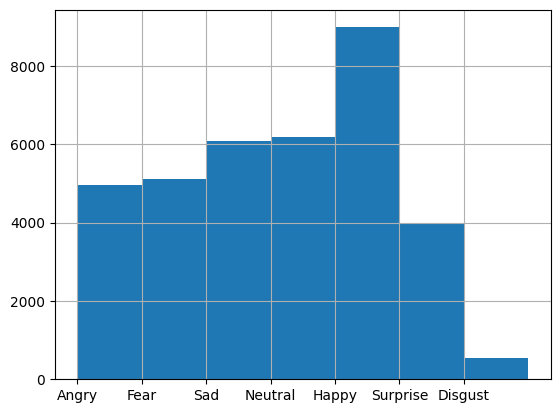

In [31]:
df['emotion'].replace(int_to_em).hist(bins=range(0,8))

dataset is unbalanced -> needs to be incorporated in the loss function!

In [32]:
weights = 1/np.bincount(df['emotion'])
weights = weights/weights.sum()
weights = torch.tensor(weights, dtype=torch.float).to(device)

print(weights)

tensor([0.0693, 0.6277, 0.0671, 0.0382, 0.0565, 0.0858, 0.0554],
       device='cuda:0')


In [33]:
# set up (weighted) loss function
WEIGHTED = True

if WEIGHTED:
  loss_fn = nn.CrossEntropyLoss(weight=weights, reduction = 'sum')
else:
  loss_fn = nn.CrossEntropyLoss(reduction = 'sum')

In [34]:
# transform data to tensors
X_train = torch.stack([torch.tensor(df_train["image"].iloc[k]) for k in range(df_train.shape[0])]).type(torch.float)

y_train = torch.tensor(df_train["emotion"].values)

X_test = torch.stack([torch.tensor(df_test["image"].iloc[k]) for k in range(df_test.shape[0])]).type(torch.float)
y_test = torch.tensor(df_test["emotion"].values)


# build dataloader for training and testing
dl_train = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
dl_test = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

#check shapes
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([28709, 48, 48]) torch.Size([28709])
torch.Size([7178, 48, 48]) torch.Size([7178])


## First model

In [35]:
def train_model(model, dl_train, dl_test, loss_fn, n_epochs = 200, lr=0.001, log_step=10):

  #initialize optimizer
  optimizer = SGD(model.parameters(), lr=lr)

  Losses_train, Losses_test, Acc_train, Acc_test = [], [], [], []

  for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    train_acc = 0

    for X, y in dl_train:
      X = X.unsqueeze(1).to(device)
      y = y.to(device)
      logits = model(X)
      loss = loss_fn(logits, y)
      train_loss += loss.item()
      train_acc += number_of_correct_predictions(logits, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if epoch % log_step == 0:
      Losses_train.append(train_loss/len(dl_train.dataset))
      Acc_train.append(train_acc/len(dl_train.dataset))

      model.eval()
      with torch.inference_mode():
        test_loss, test_acc = test_model(model, dl_test, loss_fn)

      Losses_test.append(test_loss)
      Acc_test.append(test_acc)

      print(f"Epoch {epoch} / {n_epochs}")
      print(f"avg. train loss {train_loss/len(dl_train.dataset):.4f} | accuracy train {train_acc/len(dl_train.dataset):.1%}")
      print(f"avg. test loss {test_loss:.6f} | accuracy test {test_acc:.1%}")
      print("---------------------------------------")

  T = np.arange(0, n_epochs, log_step)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle('Loss and Accuracy')
  ax1.plot(T, Losses_train, label="train")
  ax1.plot(T, Losses_test, label="test")
  ax2.plot(T, Acc_train, label="train")
  ax2.plot(T, Acc_test, label="test")
  plt.legend()
  plt.show()

Epoch 0 / 100
avg. train loss 0.1308 | accuracy train 15.1%
avg. test loss 0.129302 | accuracy test 19.9%
---------------------------------------
Epoch 10 / 100
avg. train loss 0.1062 | accuracy train 34.5%
avg. test loss 0.103105 | accuracy test 39.5%
---------------------------------------
Epoch 20 / 100
avg. train loss 0.0841 | accuracy train 47.1%
avg. test loss 0.095440 | accuracy test 48.4%
---------------------------------------
Epoch 30 / 100
avg. train loss 0.0694 | accuracy train 55.2%
avg. test loss 0.098812 | accuracy test 52.1%
---------------------------------------
Epoch 40 / 100
avg. train loss 0.0583 | accuracy train 62.3%
avg. test loss 0.096290 | accuracy test 53.5%
---------------------------------------
Epoch 50 / 100
avg. train loss 0.0418 | accuracy train 73.4%
avg. test loss 0.110720 | accuracy test 54.3%
---------------------------------------
Epoch 60 / 100
avg. train loss 0.0338 | accuracy train 78.9%
avg. test loss 0.116998 | accuracy test 54.1%
------------

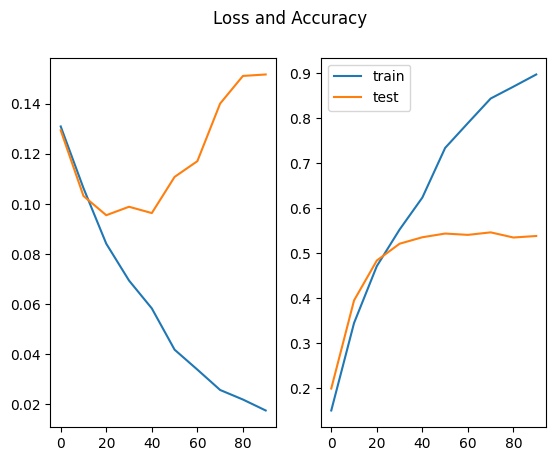

In [36]:
model_cnn = SimpleCNN().to(device)

train_model(model_cnn, dl_train, dl_test, loss_fn, n_epochs=100, log_step=10)

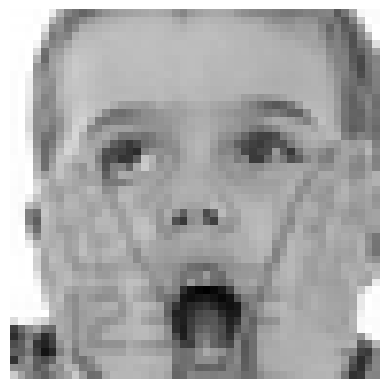

Correct label =  Surprise
Predicted label =  Surprise


In [37]:
# predict a ranodm test image:

rdm_idx = np.random.randint(0, X_test.shape[0])
rdm_img = X_test[rdm_idx]
correct_label = int_to_em[y_test[rdm_idx].item()]

plt.imshow(rdm_img, cmap="gray")
plt.axis("off")
plt.show()

print("Correct label = ", correct_label)
print("Predicted label = ", make_prediction(model_cnn, rdm_img))


## Second model

Epoch 0 / 100
avg. train loss 0.1303 | accuracy train 10.8%
avg. test loss 0.130628 | accuracy test 11.5%
---------------------------------------
Epoch 10 / 100
avg. train loss 0.1028 | accuracy train 38.9%
avg. test loss 0.098795 | accuracy test 42.6%
---------------------------------------
Epoch 20 / 100
avg. train loss 0.0667 | accuracy train 57.8%
avg. test loss 0.088744 | accuracy test 55.0%
---------------------------------------
Epoch 30 / 100
avg. train loss 0.0375 | accuracy train 76.8%
avg. test loss 0.110863 | accuracy test 56.1%
---------------------------------------
Epoch 40 / 100
avg. train loss 0.0184 | accuracy train 89.2%
avg. test loss 0.133026 | accuracy test 56.7%
---------------------------------------
Epoch 50 / 100
avg. train loss 0.0098 | accuracy train 94.6%
avg. test loss 0.156997 | accuracy test 57.5%
---------------------------------------
Epoch 60 / 100
avg. train loss 0.0048 | accuracy train 97.6%
avg. test loss 0.192219 | accuracy test 58.1%
------------

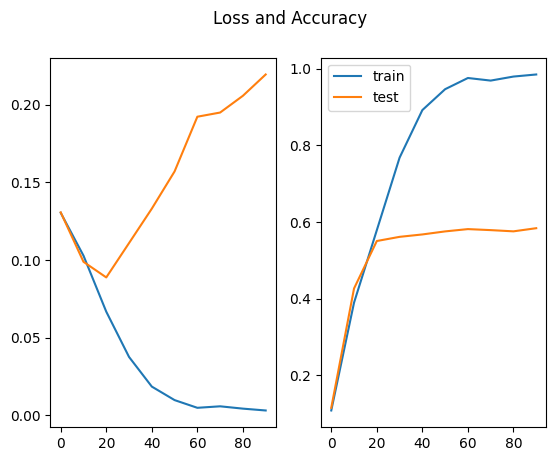

In [38]:
model_vgg = VGGModel().to(device)

train_model(model_vgg, dl_train, dl_test, loss_fn, n_epochs=100, log_step=10)

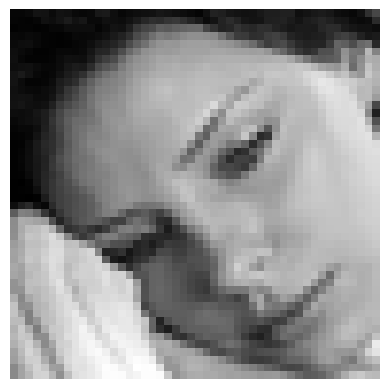

Correct label =  Sad
Predicted label =  Sad


In [42]:
# predict a random test image:

rdm_idx = np.random.randint(0, X_test.shape[0])
rdm_img = X_test[rdm_idx]
correct_label = int_to_em[y_test[rdm_idx].item()]

plt.imshow(rdm_img, cmap="gray")
plt.axis("off")
plt.show()

print("Correct label = ", correct_label)
print("Predicted label = ", make_prediction(model_vgg, rdm_img))